In [1]:
# Import the dependencies

import os
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt


2024-06-06 20:30:05.327645: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Define directory containing the csv files
dir_path = Path("../Resources")

# create an empty list to hold the dataframes 
dfs = []

# loop through each file in the directory
for file in os.listdir(dir_path):
    # check if the file is a csv file
    if file.endswith(".csv"):
        # extract the ticker symbol from the file name (assuming the file name is the ticker symbol)
        ticker = file.replace(".csv", "")
        # Read the file into a DataFrame
        stocks_df = pd.read_csv(dir_path / file)
        # Add a column to the DataFrame to store the ticker symbol
        stocks_df["Ticker"] = ticker
        # add the dataframe to the list
        dfs.append(stocks_df)
        
# concatenate the dataframes in the list
combined_stocks_df = pd.concat(dfs, ignore_index=True)

# Display the combined DataFrame to verify
print(combined_stocks_df.head())

         Date  Open      High       Low     Close  Adj Close     Volume Ticker
0  1990-02-16   0.0  0.079861  0.073785  0.077257   0.052392  940636800   CSCO
1  1990-02-20   0.0  0.079861  0.074653  0.079861   0.054158  151862400   CSCO
2  1990-02-21   0.0  0.078993  0.075521  0.078125   0.052980   70531200   CSCO
3  1990-02-22   0.0  0.081597  0.078993  0.078993   0.053569   45216000   CSCO
4  1990-02-23   0.0  0.079861  0.078125  0.078559   0.053275   44697600   CSCO


/var/folders/f4/7lkrmhr91498yvvn03jsc52c0000gp/T/ipykernel_4753/227121164.py:21: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined_stocks_df = pd.concat(dfs, ignore_index=True)


In [3]:
# view the shape of the data
print(combined_stocks_df.shape)

(524382, 8)


In [4]:
# change the type in 'date' column to datetime
combined_stocks_df["Date"] = pd.to_datetime(combined_stocks_df["Date"])

# Filter the data for the last 5 years from today
fifteen_years_ago = pd.Timestamp.today() - pd.DateOffset(years=15)
stocks_data_filtered = combined_stocks_df[combined_stocks_df["Date"] >= fifteen_years_ago]

print(stocks_data_filtered.head())
print(stocks_data_filtered.tail())



           Date       Open       High        Low      Close  Adj Close  \
4865 2009-06-08  19.740000  20.059999  19.530001  19.870001  13.474829   
4866 2009-06-09  19.950001  20.200001  19.680000  20.080000  13.617237   
4867 2009-06-10  20.190001  20.240000  19.600000  19.950001  13.529078   
4868 2009-06-11  19.930000  20.350000  19.900000  20.100000  13.630805   
4869 2009-06-12  19.930000  20.000000  19.629999  19.910000  13.501950   

        Volume Ticker  
4865  42855000   CSCO  
4866  49764200   CSCO  
4867  58386500   CSCO  
4868  44781700   CSCO  
4869  41365200   CSCO  
             Date        Open        High         Low       Close   Adj Close  \
524377 2024-04-17  950.000000  952.489990  910.260010  912.260010  912.260010   
524378 2024-04-18  909.229980  909.330017  884.390015  888.919983  888.919983   
524379 2024-04-19  894.940002  899.679993  861.950012  870.250000  870.250000   
524380 2024-04-22  876.400024  878.739990  857.979980  868.070007  868.070007   
524381

In [5]:
# Initialize a dictionary to hold the MSE for each stock symbol
mse_dict = {}

# Initialize a dictionary to hold the predictions for each stock symbol
predictions_dict = {}

# Group the data by ticker symbol
stocks_grouped = stocks_data_filtered.groupby("Ticker")

# # Iterate through each group (stock symbol)
for ticker, group in stocks_grouped:
    # Create a copy of the group's data
    group_copy = group.copy()
    
    # Set the date as the index
    group_copy.set_index("Date", inplace=True)
    
    # Define a feature int he data for previous date closing prices
    group_copy["Previous Day Close"] = group_copy["Close"].shift(1)
    
    # Define a feature in the data for the volume
    group_copy["Volume Difference"] = group_copy["Volume"].diff()
    
    # Drop rows with NaN values
    group_copy = group_copy.dropna()
    
    # Define the features (X) and the target (y) variables for training purposes
    X = group_copy[["Previous Day Close", "Volume Difference"]]
    y = group_copy["Close"].values.reshape(-1, 1) 
    
    # split the data into training and testing sets chronologically
    split = int(0.7 * len(X))
    X_train = X[: split]
    X_test = X[split:]
    y_train = y[: split]
    y_test = y[split:]
    
    # Train the model
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    # Make predictions using the testing data
    predictions = model.predict(X_test)
    
    # Calculate the mean_squared_error on the testing data
    mse = mean_squared_error(y_test, predictions)
    
    # Store the MSE in the dictionary
    mse_dict[ticker] = mse
    
        # Make a prediction for the values of the stock over the next year starting from the last date for each stock in the dataset
    # Create a dataframe to hold the predictions
    future_dates = pd.date_range(start=group_copy.index[-1], periods=60, freq='M')
    future_dates_df = pd.DataFrame(future_dates, columns=["Date"])
    future_dates_df.set_index("Date", inplace=True)
    
    # Initialize previous_close with the last available close value
    previous_close = group_copy["Close"].iloc[-1]
    volume_difference = 0

    # Predict the future values iteratively
    future_closes = []
    for date in future_dates_df.index:
        # prepare the input data for prediction
        input_data = pd.DataFrame({"Previous Day Close": [previous_close], "Volume Difference": [volume_difference]})
        # Make the prediction
        predicted_close = model.predict(input_data)[0][0]
        # Append the predicted close to the list
        future_closes.append(predicted_close)
        # Update previous_close for the next iteration
        previous_close = predicted_close
    
    # Add the predictions to the dataframe
    future_dates_df["Close"] = future_closes
    
    # Store the predictions in the dictionary
    predictions_dict[ticker] = future_dates_df

/var/folders/f4/7lkrmhr91498yvvn03jsc52c0000gp/T/ipykernel_4753/3075346880.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_dates = pd.date_range(start=group_copy.index[-1], periods=60, freq='M')
/var/folders/f4/7lkrmhr91498yvvn03jsc52c0000gp/T/ipykernel_4753/3075346880.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_dates = pd.date_range(start=group_copy.index[-1], periods=60, freq='M')
/var/folders/f4/7lkrmhr91498yvvn03jsc52c0000gp/T/ipykernel_4753/3075346880.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_dates = pd.date_range(start=group_copy.index[-1], periods=60, freq='M')
/var/folders/f4/7lkrmhr91498yvvn03jsc52c0000gp/T/ipykernel_4753/3075346880.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_dates = pd.date_range(st

In [6]:
# Display the MSE for each stock ticker
for ticker, mse in mse_dict.items():
    print(f"Stock Ticker: {ticker}, Mean Squared Error: {mse}")

Stock Ticker: AAPL, Mean Squared Error: 6.686896436331863
Stock Ticker: ADBE, Mean Squared Error: 115.18725681464464
Stock Ticker: ADI, Mean Squared Error: 9.825771106506346
Stock Ticker: ADP, Mean Squared Error: 10.924329180141603
Stock Ticker: ALGN, Mean Squared Error: 138.33453959812192
Stock Ticker: AMD, Mean Squared Error: 10.46712155285757
Stock Ticker: AMGN, Mean Squared Error: 14.276508681983962
Stock Ticker: AMZN, Mean Squared Error: 9.125115254955327
Stock Ticker: ANSS, Mean Squared Error: 45.957691786522695
Stock Ticker: ASML, Mean Squared Error: 219.11183194199288
Stock Ticker: AVGO, Mean Squared Error: 201.5657143601602
Stock Ticker: BIIB, Mean Squared Error: 67.83004531623504
Stock Ticker: BKNG, Mean Squared Error: 2574.3280299092285
Stock Ticker: CDNS, Mean Squared Error: 12.307801750149217
Stock Ticker: CDW, Mean Squared Error: 8.985980707537006
Stock Ticker: CHKP, Mean Squared Error: 3.7585501460146693
Stock Ticker: CHTR, Mean Squared Error: 103.02022536776691
Stock Ti

In [7]:
# Display the predictions for each stock ticker
for ticker, future_dates_df in predictions_dict.items():
    print(f"Predictions for {ticker}:")
    print(future_dates_df)


Predictions for AAPL:
                 Close
Date                  
2024-04-30  166.991037
2024-05-31  167.082123
2024-06-30  167.173255
2024-07-31  167.264430
2024-08-31  167.355650
2024-09-30  167.446915
2024-10-31  167.538224
2024-11-30  167.629577
2024-12-31  167.720975
2025-01-31  167.812417
2025-02-28  167.903904
2025-03-31  167.995435
2025-04-30  168.087011
2025-05-31  168.178631
2025-06-30  168.270296
2025-07-31  168.362006
2025-08-31  168.453760
2025-09-30  168.545559
2025-10-31  168.637403
2025-11-30  168.729291
2025-12-31  168.821224
2026-01-31  168.913202
2026-02-28  169.005225
2026-03-31  169.097292
2026-04-30  169.189404
2026-05-31  169.281561
2026-06-30  169.373763
2026-07-31  169.466010
2026-08-31  169.558302
2026-09-30  169.650638
2026-10-31  169.743020
2026-11-30  169.835446
2026-12-31  169.927918
2027-01-31  170.020434
2027-02-28  170.112996
2027-03-31  170.205602
2027-04-30  170.298254
2027-05-31  170.390951
2027-06-30  170.483693
2027-07-31  170.576480
2027-08-31  

In [8]:
# Define the base path as the parent directory of "Notebooks" and "Resources"
base_path = os.path.abspath(os.path.join(os.getcwd(), os.pardir))

# Create a directory named "Predictions" within the base path if it doesn't exist
predictions_folder = os.path.join(base_path, "Five Year Predictions")
if not os.path.exists(predictions_folder):
    os.makedirs(predictions_folder)

# Save the Predictions results to individual files in the "Predictions" folder
for ticker, future_dates_df in predictions_dict.items():
    prediction_file_path = os.path.join(predictions_folder, f"predictions_{ticker}.csv")
    future_dates_df.to_csv(prediction_file_path)

print(f"Prediction results saved to the folder: {predictions_folder}")

# Create a directory named "MSE" within the base path if it doesn't exist
mse_folder = os.path.join(base_path, "MSE Output Five Year")
if not os.path.exists(mse_folder):
    os.makedirs(mse_folder)

# Define the path to save the MSE results file
mse_file_path = os.path.join(mse_folder, "mse_results.csv")

# Save the MSE results to a file in the "MSE" folder
mse_df = pd.DataFrame(list(mse_dict.items()), columns=["Stock Ticker", "Mean Squared Error"])
mse_df.to_csv(mse_file_path, index=False)

print(f"MSE results saved to: {mse_file_path}")


Prediction results saved to the folder: /Users/paulettepetracco/Bootcamp_Code_Challenges/GH_Repositories/Project_4/stockmarket-machinelearningproject/Five Year Predictions
MSE results saved to: /Users/paulettepetracco/Bootcamp_Code_Challenges/GH_Repositories/Project_4/stockmarket-machinelearningproject/MSE Output Five Year/mse_results.csv


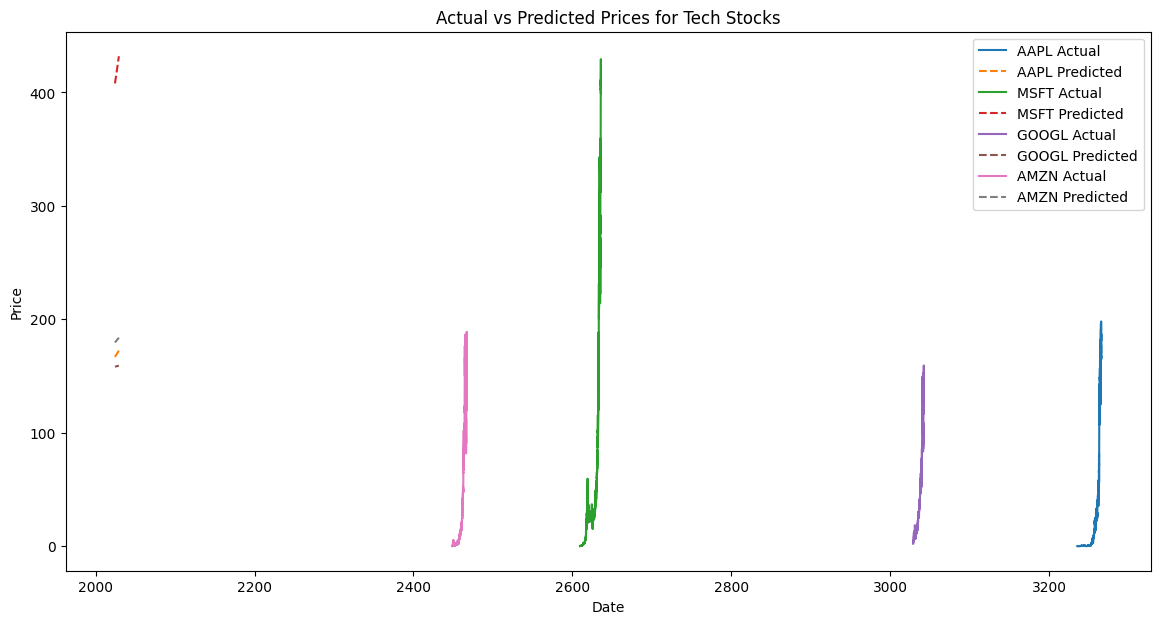

In [13]:
# Function to plot actual vs predicted prices for multiple stocks
def plot_multiple_stocks_actual_vs_predicted(tickers, combined_stocks_df, predictions_dict):
    plt.figure(figsize=(14, 7))
    
    for ticker in tickers:
        # Filter actual prices for the ticker
        actual_prices = combined_stocks_df[combined_stocks_df['Ticker'] == ticker]
        # Get predicted prices for the ticker
        predicted_prices = predictions_dict[ticker]
        
        # Plot actual prices
        plt.plot(actual_prices.index, actual_prices['Close'], label=f"{ticker} Actual")
        # Plot predicted prices
        plt.plot(predicted_prices.index, predicted_prices['Close'], linestyle='dashed', label=f"{ticker} Predicted")
    
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.title("Actual vs Predicted Prices for Tech Stocks")
    plt.legend()
    plt.show()

# List of tickers to compare
tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN']

# Ensure combined_stocks_df has a 'Ticker' column
# Assuming 'combined_stocks_df' already has the 'Ticker' column after loading data
# combined_stocks_df['Ticker'] = ...

# Plot the actual vs predicted prices for the specified tickers
plot_multiple_stocks_actual_vs_predicted(tickers, combined_stocks_df, predictions_dict)


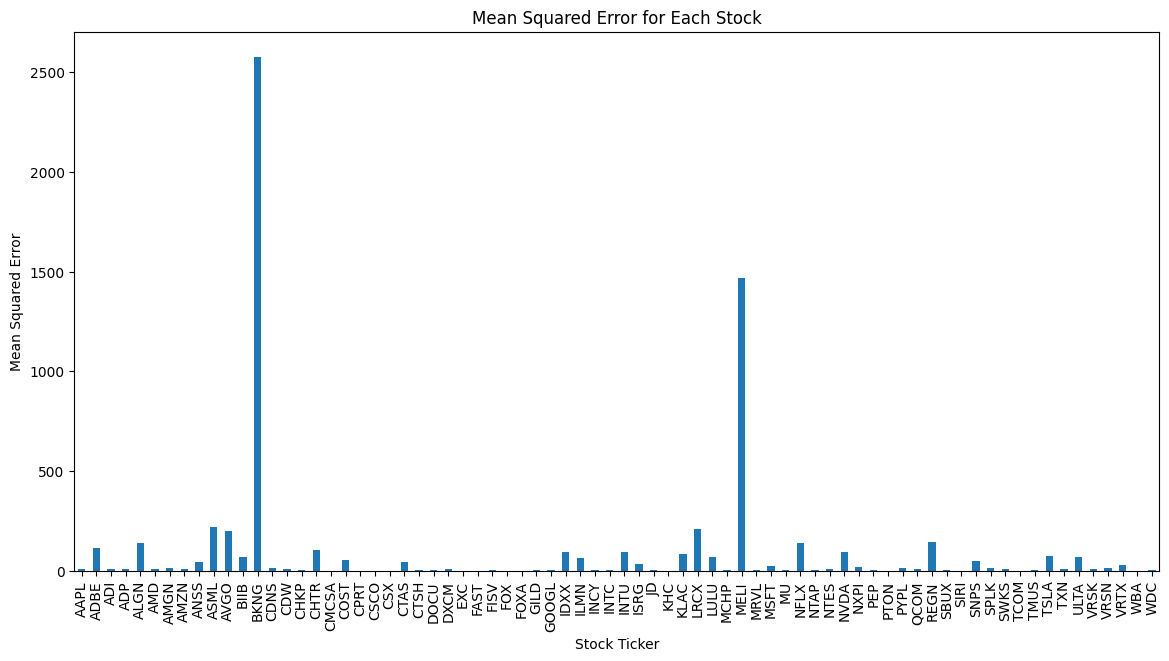

In [10]:
def plot_mse(mse_dict):
    mse_df = pd.DataFrame(list(mse_dict.items()), columns=["Stock Ticker", "Mean Squared Error"])
    mse_df.plot(kind='bar', x='Stock Ticker', y='Mean Squared Error', legend=False, figsize=(14, 7))
    plt.ylabel("Mean Squared Error")
    plt.title("Mean Squared Error for Each Stock")
    plt.show()

# Example usage
plot_mse(mse_dict)

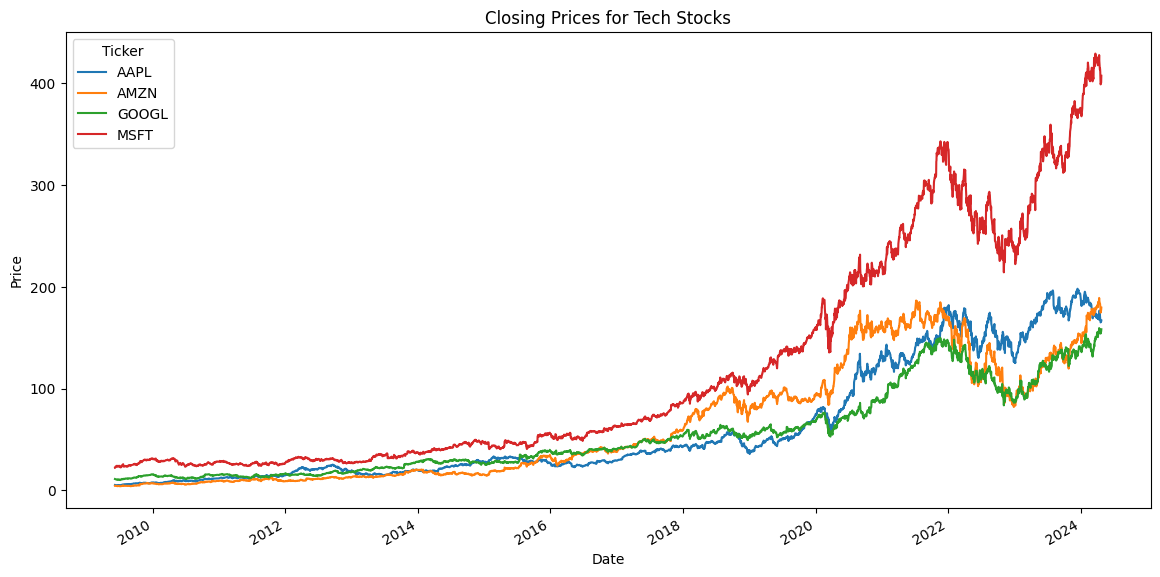

In [15]:
# create a line graph with multiple stocks: BIIB, GILD, INCY, VRTX
# Filter the data for the last 15 years from today
fifteen_years_ago = pd.Timestamp.today() - pd.DateOffset(years=15)
stocks_data_filtered = combined_stocks_df[combined_stocks_df["Date"] >= fifteen_years_ago] 

# Define the list of tickers to plot
tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN']

# Filter the data for the specified tickers
filtered_data = stocks_data_filtered[stocks_data_filtered["Ticker"].isin(tickers)]

# Pivot the data to have the tickers as columns
pivoted_data = filtered_data.pivot(index="Date", columns="Ticker", values="Close")

# Plot the data
pivoted_data.plot(figsize=(14, 7))
plt.xlabel("Date")
plt.ylabel("Price")
plt.title("Closing Prices for Tech Stocks")
plt.show()

# Function to plot the actual and predicted prices for a stock
def plot_actual_vs_predicted(ticker, historical_df, predictions_df):
    plt.figure(figsize=(14, 7))
    plt.plot(historical_df.index, historical_df['Close'], label="Actual Prices")
    plt.plot(predictions_df.index, predictions_df['Close'], label="Predicted Prices", linestyle='dashed')
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.title(f"Actual vs Predicted Prices for {ticker}")
    plt.legend()
    plt.show()

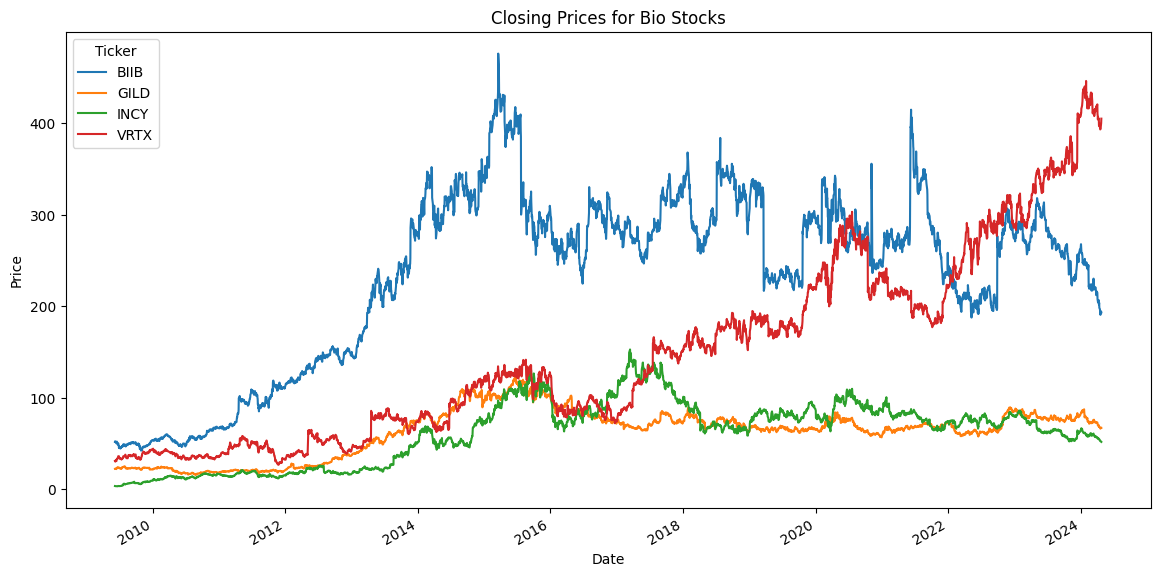

In [11]:
# create a line graph with multiple stocks: BIIB, GILD, INCY, VRTX
# Filter the data for the last 15 years from today
fifteen_years_ago = pd.Timestamp.today() - pd.DateOffset(years=15)
stocks_data_filtered = combined_stocks_df[combined_stocks_df["Date"] >= fifteen_years_ago] 

# Define the list of tickers to plot
tickers = ["BIIB", "GILD", "INCY", "VRTX"]

# Filter the data for the specified tickers
filtered_data = stocks_data_filtered[stocks_data_filtered["Ticker"].isin(tickers)]

# Pivot the data to have the tickers as columns
pivoted_data = filtered_data.pivot(index="Date", columns="Ticker", values="Close")

# Plot the data
pivoted_data.plot(figsize=(14, 7))
plt.xlabel("Date")
plt.ylabel("Price")
plt.title("Closing Prices for Bio Stocks")
plt.show()

# Function to plot the actual and predicted prices for a stock
def plot_actual_vs_predicted(ticker, historical_df, predictions_df):
    plt.figure(figsize=(14, 7))
    plt.plot(historical_df.index, historical_df['Close'], label="Actual Prices")
    plt.plot(predictions_df.index, predictions_df['Close'], label="Predicted Prices", linestyle='dashed')
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.title(f"Actual vs Predicted Prices for {ticker}")
    plt.legend()
    plt.show()

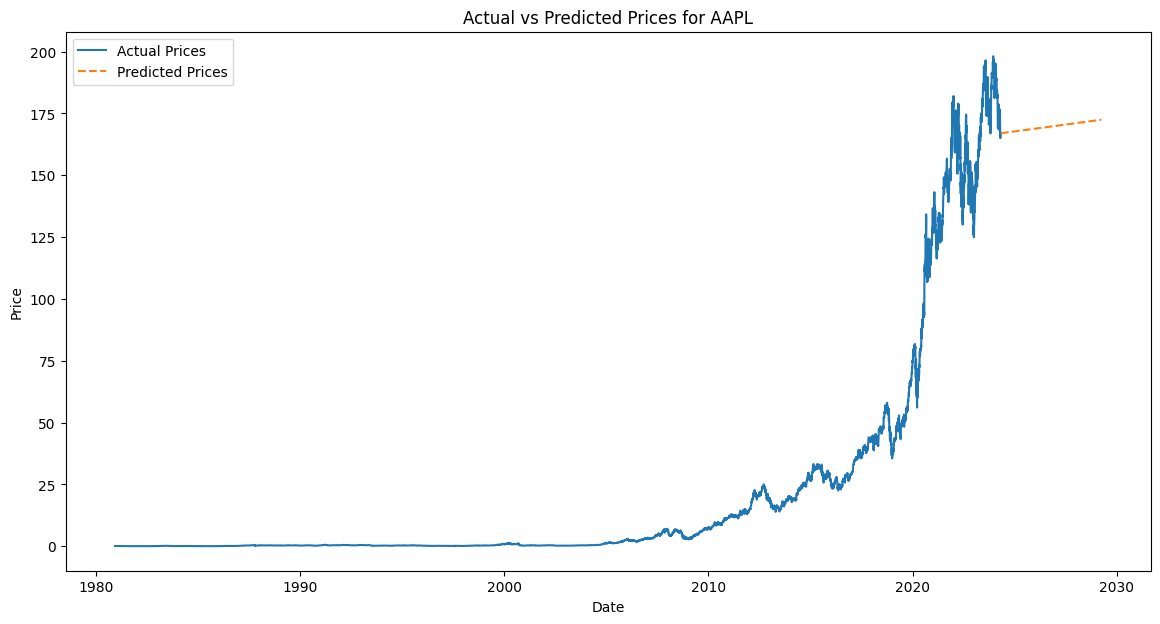

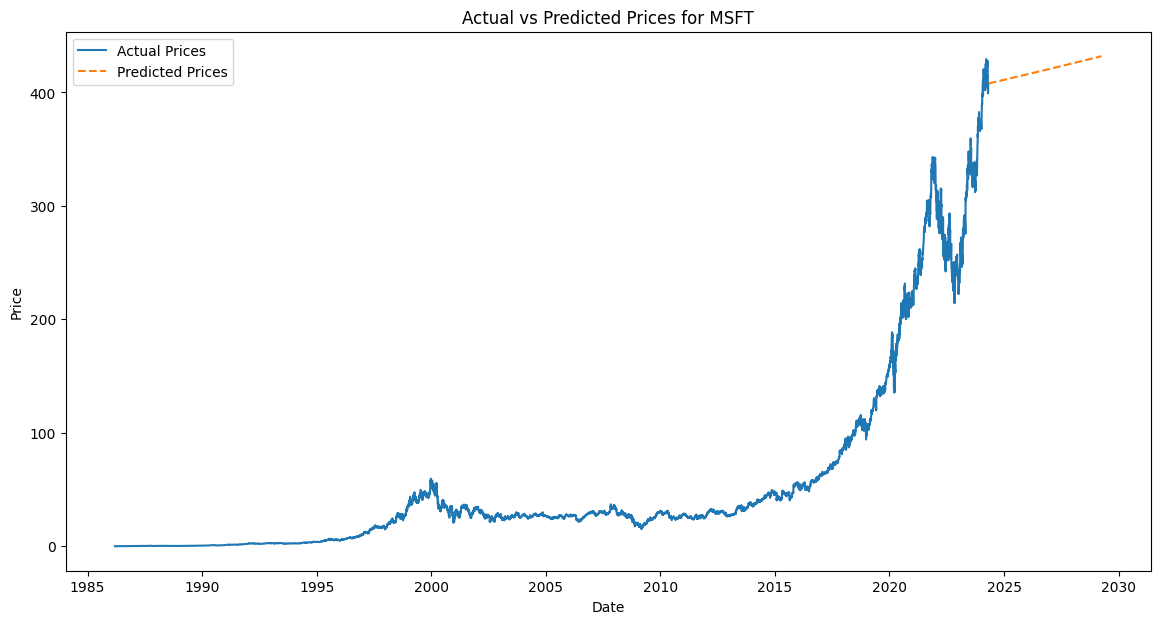

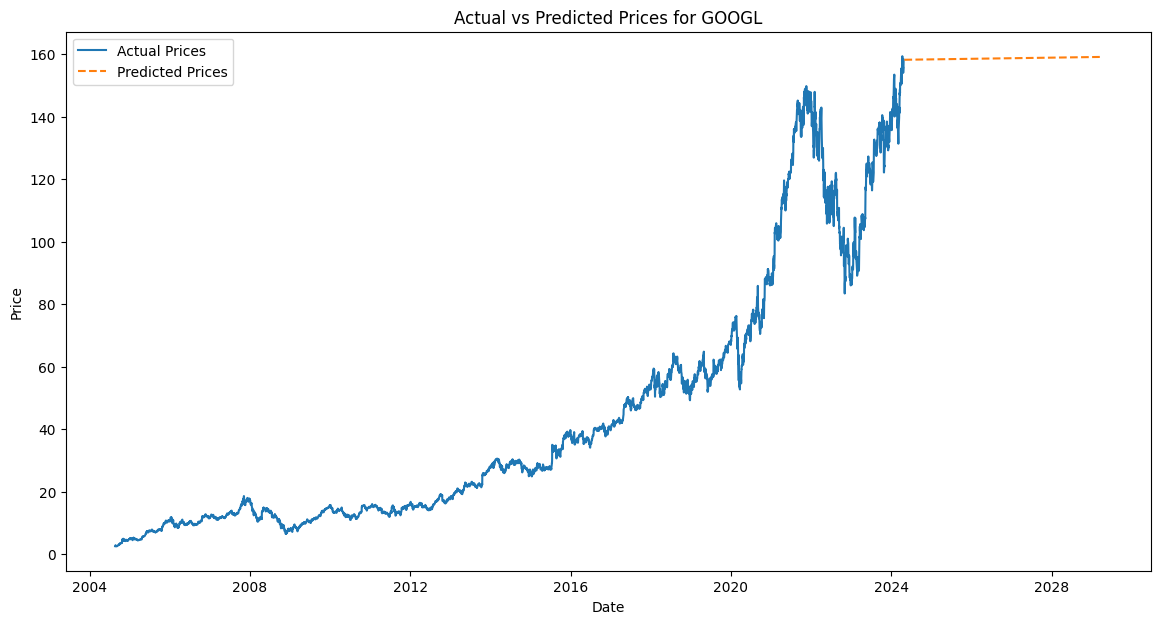

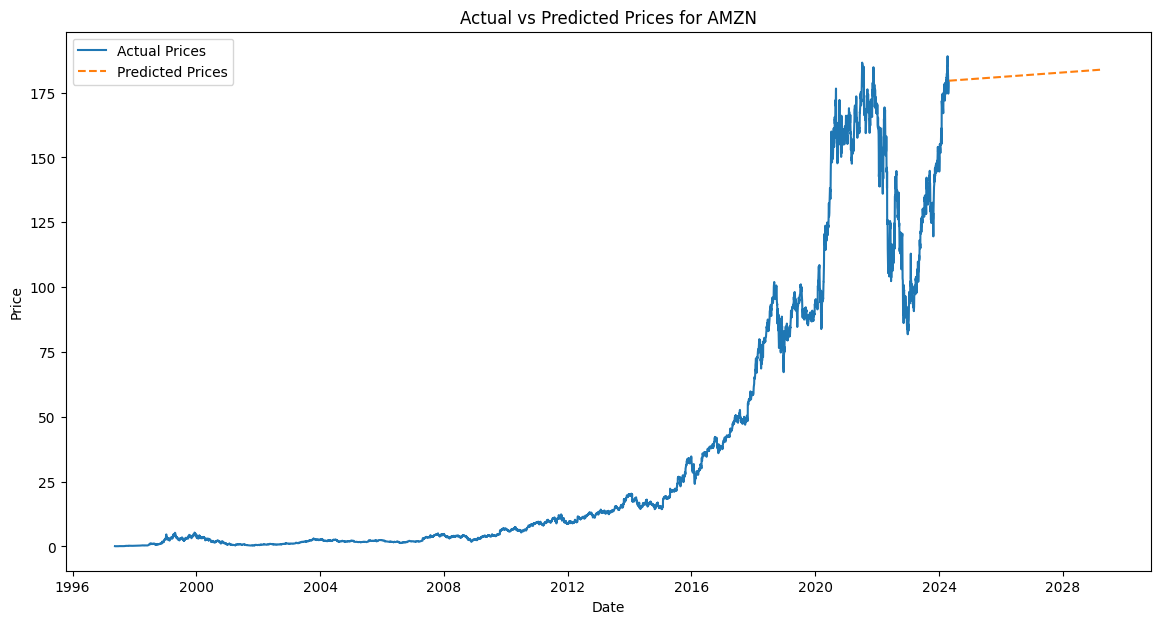

In [16]:
# create a line graph with bio stocks: BIIB, GILD, INCY, VRTX for predicted prices for the next 5 years
# Define the list of tickers to plot
tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN']

# Plot the actual vs predicted prices for the specified tickers
for ticker in tickers:
    # Get the historical data for the stock
    historical_data = combined_stocks_df[combined_stocks_df["Ticker"] == ticker]
    historical_data.set_index("Date", inplace=True)
    
    # Get the predicted prices for the stock
    predicted_data = predictions_dict[ticker]
    
    # Plot the actual vs predicted prices
    plot_actual_vs_predicted(ticker, historical_data, predicted_data)
    
# Function to plot the actual and predicted prices for a stock
def plot_actual_vs_predicted(ticker, historical_df, predictions_df):
    plt.figure(figsize=(14, 7))
    plt.plot(historical_df.index, historical_df['Close'], label="Actual Prices")
    plt.plot(predictions_df.index, predictions_df['Close'], label="Predicted Prices", linestyle='dashed')
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.title(f"Actual vs Predicted Prices for {ticker}")
    plt.legend()
    plt.show()

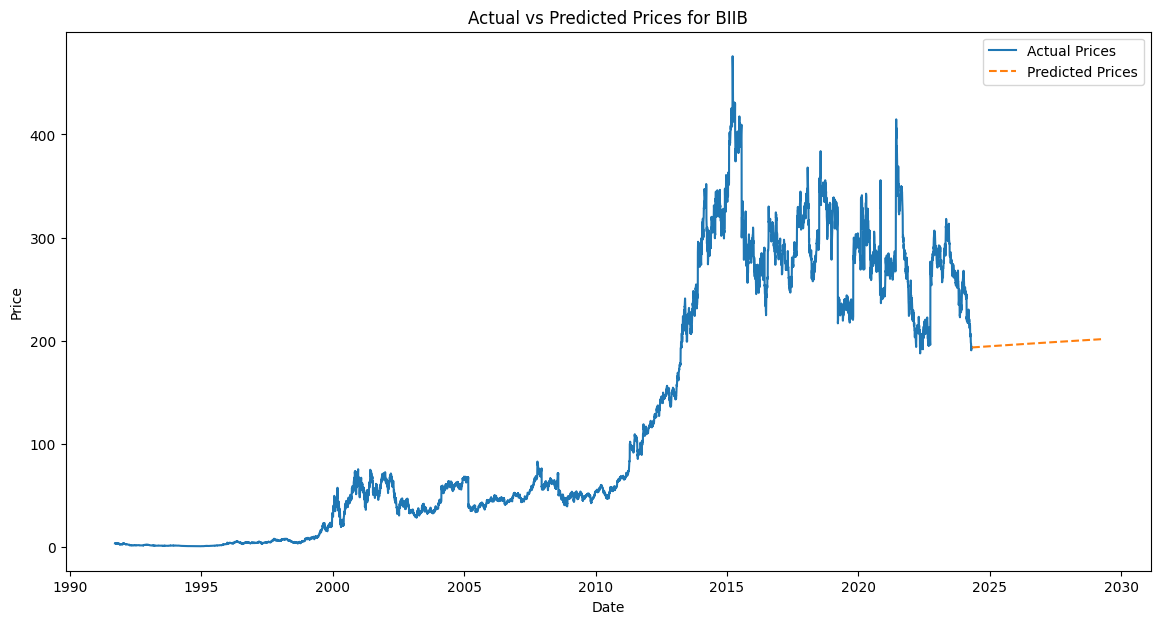

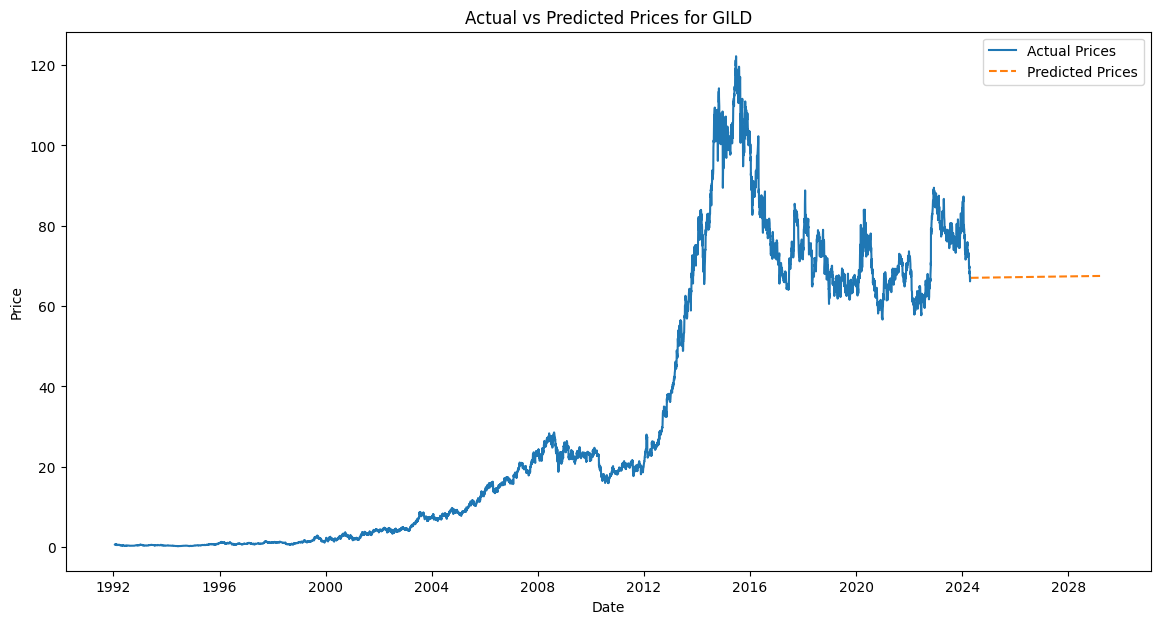

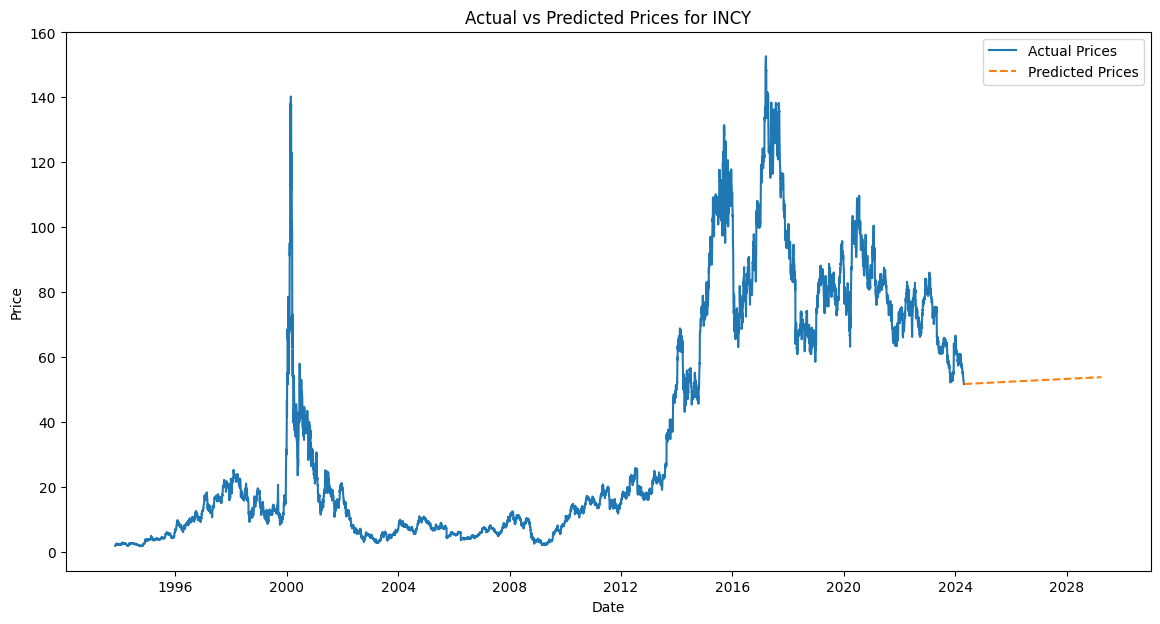

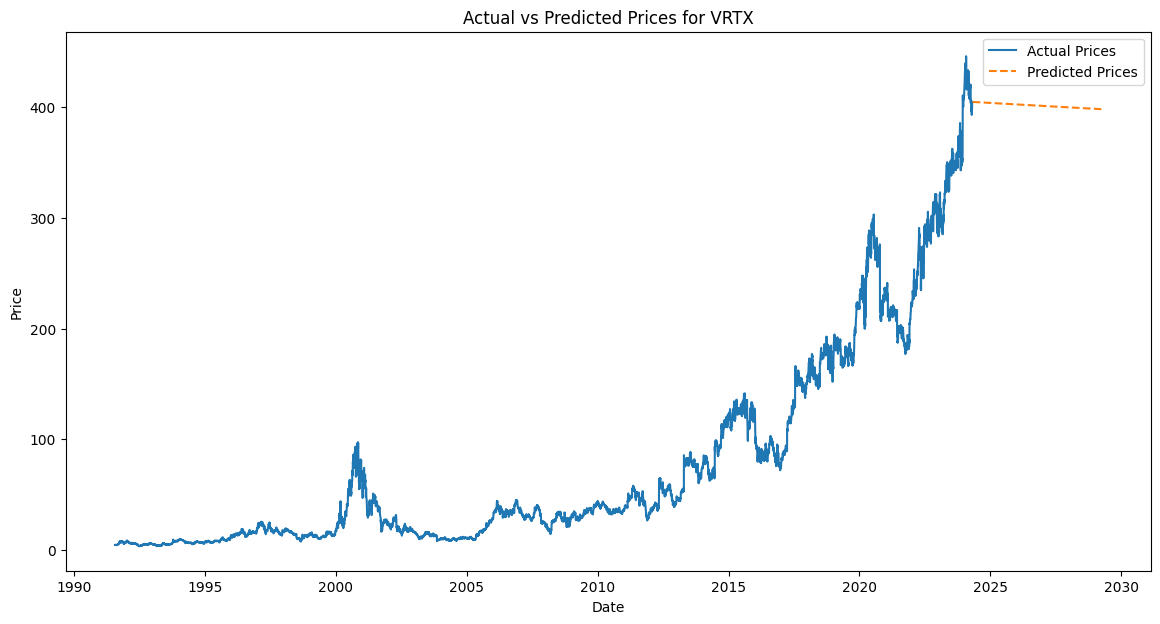

In [12]:
# create a line graph with bio stocks: BIIB, GILD, INCY, VRTX for predicted prices for the next 5 years
# Define the list of tickers to plot
tickers = ['BIIB', 'GILD', 'INCY', 'VRTX']

# Plot the actual vs predicted prices for the specified tickers
for ticker in tickers:
    # Get the historical data for the stock
    historical_data = combined_stocks_df[combined_stocks_df["Ticker"] == ticker]
    historical_data.set_index("Date", inplace=True)
    
    # Get the predicted prices for the stock
    predicted_data = predictions_dict[ticker]
    
    # Plot the actual vs predicted prices
    plot_actual_vs_predicted(ticker, historical_data, predicted_data)
    
# Function to plot the actual and predicted prices for a stock
def plot_actual_vs_predicted(ticker, historical_df, predictions_df):
    plt.figure(figsize=(14, 7))
    plt.plot(historical_df.index, historical_df['Close'], label="Actual Prices")
    plt.plot(predictions_df.index, predictions_df['Close'], label="Predicted Prices", linestyle='dashed')
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.title(f"Actual vs Predicted Prices for {ticker}")
    plt.legend()
    plt.show()